# COGS 108 - EDA Checkpoint

# Names

- Li-An Wu
- Tony Lin
- Ray Huang
- Steven Kan

<a id='research_question'></a>
# Research Question

Does the GDP or poverty rate of a country affect the death/infected/recovered rate from COVID-19?

# Setup

In [1]:
## YOUR CODE HERE
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Describe your data cleaning steps here.

## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

Describe your data cleaning steps here.

1. drop all non relevent (not needed) columns
2. remove outliers





In [2]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
covid_death = pd.read_csv("worldometer_coronavirus.csv")
GDP_country = pd.read_csv('WEO_Data.csv', encoding = "ISO-8859-1")
poverty = pd.read_csv("csvData.csv")

In [3]:
#covid_death.describe(include='all')

In [4]:
#Removing commas from numbers
covid_death = covid_death.replace(',','', regex=True)
# Convert string to integer
covid_death['Total Cases'] = pd.to_numeric(covid_death['Total Cases'])
covid_death['Total Deaths'] = pd.to_numeric(covid_death['Total Deaths'])
covid_death['Total Recovered'] = pd.to_numeric(covid_death['Total Recovered'])
covid_death['Serious/Critical'] = pd.to_numeric(covid_death['Serious/Critical'])
covid_death['TotCases/ 1M pop'] = pd.to_numeric(covid_death['TotCases/ 1M pop'])
covid_death['Deaths/1M pop'] = pd.to_numeric(covid_death['Deaths/1M pop'])
covid_death['Total Tests'] = pd.to_numeric(covid_death['Total Tests'])
covid_death['Tests/1M pop'] = pd.to_numeric(covid_death['Tests/1M pop'])
covid_death['Population'] = pd.to_numeric(covid_death['Population'])
covid_death.describe()

,Total Cases,Total Deaths,Total Recovered,Serious/Critical,TotCases/ 1M pop,Deaths/1M pop,Total Tests,Tests/1M pop,Population
count,2.220000e+02,2.040000e+02,2.190000e+02,151.000000,221.000000,203.000000,2.030000e+02,2.030000e+02,2.190000e+02
mean,1.465086e+06,3.502314e+04,1.103173e+06,1987.450331,21311.257014,398.817241,7.494558e+06,4.121701e+05,3.564332e+07
std,1.045056e+07,2.380688e+05,7.809048e+06,11585.278184,25969.667967,508.146946,3.107422e+07,6.904285e+05,1.401806e+08
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,3.000000,0.200000,4.700000e+02,5.760000e+02,8.020000e+02
25%,3.276500e+03,7.975000e+01,2.249500e+03,9.000000,1298.000000,27.500000,9.255550e+04,4.579650e+04,6.434905e+05
50%,2.963150e+04,6.100000e+02,2.021000e+04,68.000000,10586.000000,134.000000,6.627070e+05,1.844170e+05,6.590113e+06
75%,2.259425e+05,4.697250e+03,1.683155e+05,318.000000,36038.000000,580.000000,3.303684e+06,4.661380e+05,2.429004e+07
max,1.084166e+08,2.381578e+06,8.060505e+07,100035.000000,134353.000000,2464.000000,3.304247e+08,5.051032e+06,1.439324e+09


In [5]:
#Dropping Unused Columns.
covid_death = covid_death.drop(columns=['New Cases', 'New Deaths', 'Active Cases', ])
GDP_country = GDP_country.drop(columns=['Subject Descriptor', 'Country/Series-specific Notes', 'Estimates Start After'])
#Adding units to GDP data to make information clear.
GDP_country = GDP_country[GDP_country['Units'] == "U.S. dollars"]
pd.set_option('display.max_rows', GDP_country.shape[0]+1)
GDP_country = GDP_country.reset_index(drop=True)
#GDP_country

In [6]:
#Coverting strings to integers
GDP_country = GDP_country.replace(',','', regex=True)
GDP_country['2019'] = pd.to_numeric(GDP_country['2019'])
GDP_country['2020'] = pd.to_numeric(GDP_country['2020'])
#GDP_country.dtypes

In [7]:
pd.set_option('display.max_rows', poverty.shape[0]+1)
poverty.head()

,country,povertyRate,pop2021
0,Turkmenistan,0.2,6117.924
1,China,0.6,1444216.107
2,Ukraine,1.3,43466.819
3,Kazakhstan,2.5,18994.962
4,Sri Lanka,4.1,21497.310


In [8]:
#Removing inconsistencies in naming of columns
GDP_country = GDP_country.rename(columns={'country': 'Country'})
GDP_countries = GDP_country['Country'].unique()
GDP_countries.sort()

covid_death_countries = covid_death['Country'].unique()
covid_death_countries.sort()

In [9]:
# GDP_countries - covid_death_countries
#main_list1 = np.setdiff1d(GDP_countries,covid_death_countries)

In [10]:
#main_list2 contains countries not including in GDP_countries 
# covid_death_countries  - GDP_countries 
#main_list2 = np.setdiff1d(covid_death_countries, GDP_countries)

In [11]:
# Renaming the inconsistency in the country names
GDP_country['Country'] = GDP_country['Country'].replace(['Brunei Darussalam'], 'Brunei')
GDP_country['Country'] = GDP_country['Country'].replace(['Central African Republic'], 'CAR')
GDP_country['Country'] = GDP_country['Country'].replace(['Czech Republic'], 'Czechia')
GDP_country['Country'] = GDP_country['Country'].replace(["Côte d\'Ivoire"], 'Ivory Coast')
GDP_country['Country'] = GDP_country['Country'].replace(['Democratic Republic of the Congo'], 'DRC')
GDP_country['Country'] = GDP_country['Country'].replace(['Hong Kong SAR'], 'Hong Kong')
GDP_country['Country'] = GDP_country['Country'].replace(['Islamic Republic of Iran'], 'Iran')
GDP_country['Country'] = GDP_country['Country'].replace(['Korea'], 'S. Korea')
GDP_country['Country'] = GDP_country['Country'].replace(['Kyrgyz Republic'], 'Kyrgyzstan')
GDP_country['Country'] = GDP_country['Country'].replace(['Lao P.D.R.'], 'Laos')
GDP_country['Country'] = GDP_country['Country'].replace(['Macao SAR'], 'Macao')
GDP_country['Country'] = GDP_country['Country'].replace(['Republic of Congo'], 'Congo')
GDP_country['Country'] = GDP_country['Country'].replace(['Slovak Republic'], 'Slovakia')
GDP_country['Country'] = GDP_country['Country'].replace(['St. Kitts and Nevis'], 'Saint Kitts and Nevis')
GDP_country['Country'] = GDP_country['Country'].replace(['St. Lucia'], 'Saint Lucia')
GDP_country['Country'] = GDP_country['Country'].replace(['St. Vincent and the Grenadines'], 'St. Vincent Grenadines')
GDP_country['Country'] = GDP_country['Country'].replace(['São Tomé and Príncipe'], 'Sao Tome and Principe')
GDP_country['Country'] = GDP_country['Country'].replace(['Taiwan Province of China'], 'Taiwan')
GDP_country['Country'] = GDP_country['Country'].replace(['The Bahamas'], 'Bahamas')
GDP_country['Country'] = GDP_country['Country'].replace(['The Gambia'], 'Gambia')
GDP_country['Country'] = GDP_country['Country'].replace(['United Arab Emirates'], 'UAE')
GDP_country['Country'] = GDP_country['Country'].replace(['United Kingdom'], 'UK')
GDP_country['Country'] = GDP_country['Country'].replace(['United States'], 'USA')
GDP_country['Country'] = GDP_country['Country'].replace(['West Bank and Gaza'], 'Palestine')

In [12]:
#1. Match the corresponding countries 
combine = pd.merge(covid_death, GDP_country, on='Country')

combine = combine.drop(columns = '2019')
combine = combine.drop(columns = 'Serious/Critical')
combine = combine.rename(columns={'2020': '2020 GDP'})

combine['Recovery Percentage'] = combine['Total Recovered'] / combine['Total Cases']
combine['GDP per Capita'] = combine['2020 GDP'] / combine['Population'] * 1e9

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

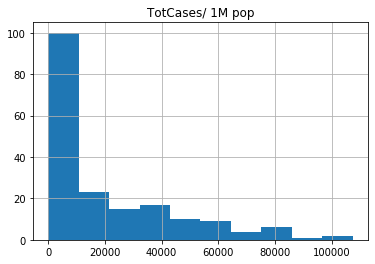

In [13]:
f2 = combine.hist(column = 'TotCases/ 1M pop')         

We plotted a histogram of the total cases per 1 million population to visualize how this variable is distributed.

The distribution for this variable doesn't seem to fit any of the common distributions, but the data was highly skewed towards the left.

We observed that for many countries, the number of cases per 1 million people remained on the low end.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c193216d0>]],
      dtype=object)

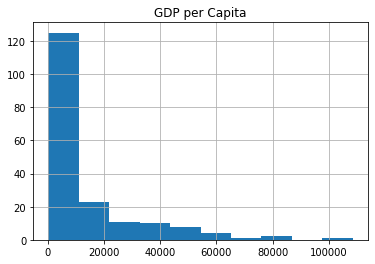

In [14]:
combine.hist(column = 'GDP per Capita')

We then plotted a histogram of the GDP per capita of all the countries. 

Again, the distribution for this variable doesn't seem to fit any of the common distributions, but the data was highly skewed towards the left. 

We observed that for the vast majority of countries, GDP per capita was low ( < 20000 USD per year)

This prompted us to divide the countries based on their GDP per capita into two groups- developing and developed. 

Note that 20,000 USD per year is just an arbitrary sum that we collectively chose and is not a typical measure for whether a country is categorized as developed or developing. In this case though, countries whose citizens earn, on average, more than 20,000 USD per year is considered developed.

In [15]:
combine_developing = combine[combine['GDP per Capita'] < 20000]
combine_developed = combine[combine['GDP per Capita'] >= 20000]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c194a6f90>]],
      dtype=object)

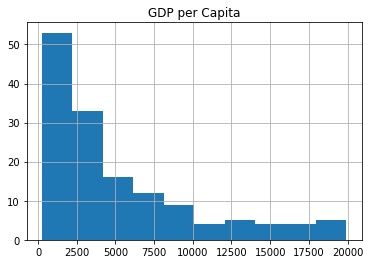

In [16]:
combine_developing.hist(column = 'GDP per Capita')

We then plotted a histogram of the GDP per capita of all the developing countries.

Again, the distribution for the variables doesn't seem to fit any of the common distributions, but the data was highly skewed towards the left. 

We surprisingly observed that for the vast majority of developing countries, GDP per capita was much lower than we initially expected, (< 5,000 USD per year)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c194db110>]],
      dtype=object)

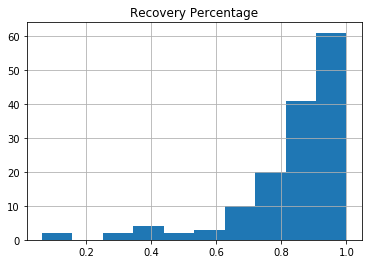

In [17]:
combine_developing.hist(column = 'Recovery Percentage')

We then plotted a histogram of the percentage of recovered patients in the developing countries.

The disitribution doesn't fit any of the common distributions, but the data was highly skewed towards the right.

We observed that the recovery percentage is quite high for most developing countries, contrary to what we initially predicted.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1962f190>]],
      dtype=object)

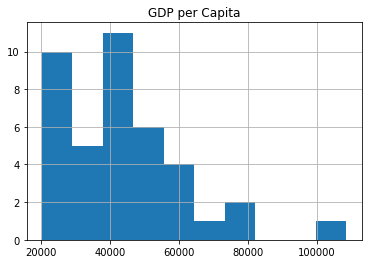

In [18]:
combine_developed.hist(column = 'GDP per Capita')

We then plotted a histogram of the GDP per capita of all the developed countries.

Again, the distribution for the variables doesn't seem to fit any of the common distributions, but the data was skewed towards the left.

We observed that there is a country with a super high GDP, upon investigating, this turned out to be a tax haven for the wealthy.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c195a4b90>]],
      dtype=object)

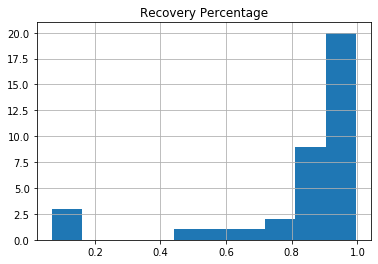

In [19]:
combine_developed.hist(column = 'Recovery Percentage')

We then plotted a histogram of the recovery percentage of all the developed countries.

Again, the distribution for the variables doesn't seem to fit any of the common distributions, but the data was skewed towards the right.

We observed that the recovery percentage is generally quite high, with 3 countries with super low recovery rates. Upon investigating, these countries had a low number of cases which hasn't concluded yet. 

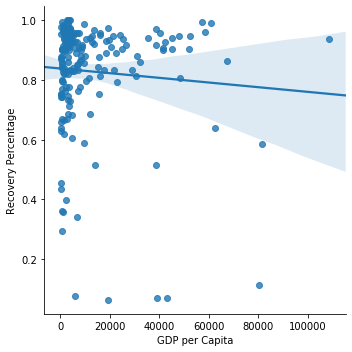

In [20]:
sns.lmplot(x='GDP per Capita', y='Recovery Percentage', data=combine, fit_reg=True);

In [21]:
outcome_1, predictors_1 = patsy.dmatrices('Q("Recovery Percentage") ~ Q("GDP per Capita")', combine)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                               OLS Regression Results                               
Dep. Variable:     Q("Recovery Percentage")   R-squared:                       0.006
Model:                                  OLS   Adj. R-squared:                  0.000
Method:                       Least Squares   F-statistic:                     1.044
Date:                      Sat, 27 Feb 2021   Prob (F-statistic):              0.308
Time:                              15:23:34   Log-Likelihood:                 47.443
No. Observations:                       182   AIC:                            -90.89
Df Residuals:                           180   BIC:                            -84.48
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

We plotted GDP per capita against recovery rate and made a linear model using OLS. Since R^2 is about 0.006, there is no sufficient evidence to support that the correlation between GDP Per Capita and Recovery Rate. This is most likely because most countries have GDP Per Capita lower than 20,000, so this graph is not normally distributed. 

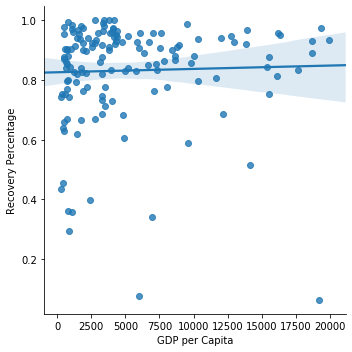

In [22]:
sns.lmplot(x='GDP per Capita', y='Recovery Percentage', data=combine_developing, fit_reg=True);

In [23]:
outcome_2, predictors_2 = patsy.dmatrices('Q("Recovery Percentage") ~ Q("GDP per Capita")', combine_developing)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                               OLS Regression Results                               
Dep. Variable:     Q("Recovery Percentage")   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.006
Method:                       Least Squares   F-statistic:                    0.1535
Date:                      Sat, 27 Feb 2021   Prob (F-statistic):              0.696
Time:                              15:23:35   Log-Likelihood:                 50.811
No. Observations:                       145   AIC:                            -97.62
Df Residuals:                           143   BIC:                            -91.67
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

Now we are focusing on the countries with less than 20,000 GDP Per Capita. We plotted GDP per capita against recovery rate and made a linear model using OLS. Since R^2 is about 0.001, there is no sufficient evidence to support that the correlation between GDP Per Capita and Recovery Rate for developing countries. 

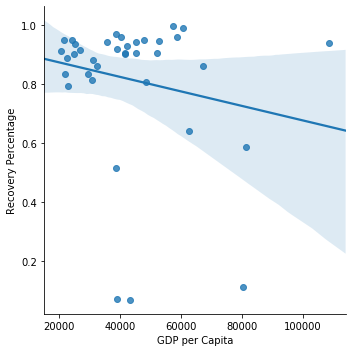

In [24]:
sns.lmplot(x='GDP per Capita', y='Recovery Percentage', data=combine_developed, fit_reg=True);

In [25]:
outcome_3, predictors_3 = patsy.dmatrices('Q("Recovery Percentage") ~ Q("GDP per Capita")', combine_developed)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                               OLS Regression Results                               
Dep. Variable:     Q("Recovery Percentage")   R-squared:                       0.038
Model:                                  OLS   Adj. R-squared:                  0.010
Method:                       Least Squares   F-statistic:                     1.376
Date:                      Sat, 27 Feb 2021   Prob (F-statistic):              0.249
Time:                              15:23:36   Log-Likelihood:                0.94799
No. Observations:                        37   AIC:                             2.104
Df Residuals:                            35   BIC:                             5.326
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

Now we are focusing on the countries with more than 20,000 GDP Per Capita. We plotted GDP per capita against recovery rate and made a linear model using OLS. Since R^2 is about 0.038, there is no sufficient evidence to support that the correlation between GDP Per Capita and Recovery Rate for developed countries. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a048e50>]],
      dtype=object)

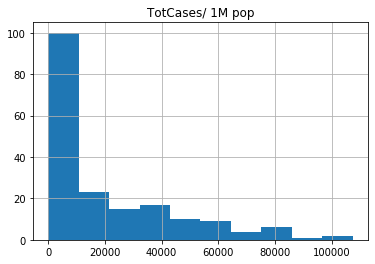

In [26]:
combine.hist(column = 'TotCases/ 1M pop', bins = 10)

We then plotted a histogram of the total cases per 1 million populatin. 

The distribution for the variables doesn't seem to fit any of the common distributions, but the data was highly skewed towards the left.

We observed that for most countries, there is less than 10000 cases per 1 million peopple.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a173a50>]],
      dtype=object)

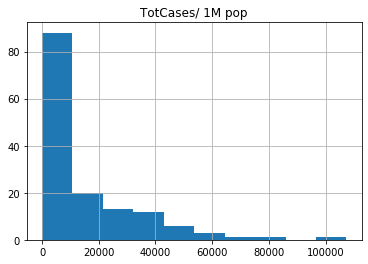

In [27]:
combine_developing.hist(column = 'TotCases/ 1M pop', bins = 10)

Again, we wanted to see if there are distribution differences between developing and developed countries. 

We plotted a histogram of the total cases per 1 million population for developing countries.

The data, again, doesn't fit any common distributions and is skewed towards the left.

We observed that again, most developing countries have a low number of cases per million people (<10000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a218b50>]],
      dtype=object)

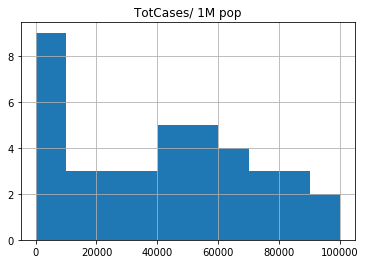

In [28]:
combine_developed.hist(column = 'TotCases/ 1M pop', bins = 10)

We then plotted a histogram of the total cases per 1 million population for developed countries.

The data, again, doesn't fit any common distributions, though one can argue that is it nearing a uniform distribution. However, the sample size is too low to say so. The data is skewed towards the left.

We observed that developed countries' total cases / 1M population was much more varied than previous variables, but still favoring the low end of <10000 cases/ 1M population.

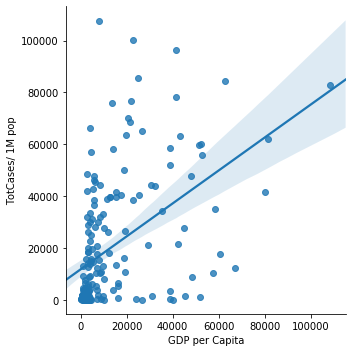

In [29]:
sns.lmplot(x='GDP per Capita', y='TotCases/ 1M pop', data=combine, fit_reg=True);

In [46]:
total_cases_outlier = combine[combine['TotCases/ 1M pop'] == max(combine['TotCases/ 1M pop'])]
total_cases_outlier

,Country,Total Cases,Total Deaths,Total Recovered,TotCases/ 1M pop,Deaths/1M pop,Total Tests,Tests/1M pop,Population,Units,Scale,2020 GDP,Recovery Percentage,GDP per Capita
91,Montenegro,67441,869.0,58210.0,107370.0,1384.0,249215.0,396767.0,628115.0,U.S. dollars,Billions,4.943,0.863125,7869.578023


Montenegro had the significant high total cases per 1 Million people among all other countries, and it may cause the correlation and R^2 to be inaccurate between GDP Per Capita and Total Cases Per 1 Million People. 

In [30]:
outcome_4, predictors_4 = patsy.dmatrices('Q("TotCases/ 1M pop") ~ Q("GDP per Capita")', combine)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()
print(res_4.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("TotCases/ 1M pop")   R-squared:                       0.228
Model:                               OLS   Adj. R-squared:                  0.224
Method:                    Least Squares   F-statistic:                     54.08
Date:                   Sat, 27 Feb 2021   Prob (F-statistic):           6.24e-12
Time:                           15:23:39   Log-Likelihood:                -2108.4
No. Observations:                    185   AIC:                             4221.
Df Residuals:                        183   BIC:                             4227.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

We plotted GDP per capita against total cases/ 1M population and made a linear model using OLS. 
Since the R^2 is about 0.228, there is no sufficient evidence to support that the correlation between GDP Per Capita and Total Cases Per 1 Million People. This is most likely because most countries have GDP Per Capita lower than 20,000, so this graph is not normally distributed. 

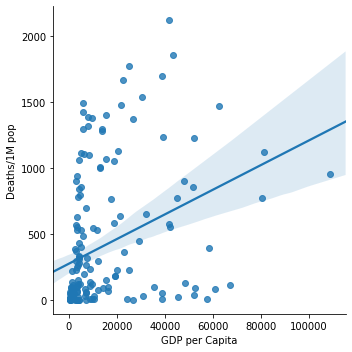

In [31]:
sns.lmplot(x='GDP per Capita', y='Deaths/1M pop', data=combine, fit_reg=True);

In [32]:
outcome_5, predictors_5 = patsy.dmatrices('Q("Deaths/1M pop") ~ Q("GDP per Capita")', combine)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Deaths/1M pop")   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     23.57
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           2.69e-06
Time:                        15:23:40   Log-Likelihood:                -1318.8
No. Observations:                 174   AIC:                             2642.
Df Residuals:                     172   BIC:                             2648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             274.3750    

We plotted GDP per capita against total deaths/ 1M population and made a linear model using OLS. 
Since the R^2 is about 0.121, there is no sufficient evidence to support that the correlation between GDP Per Capita and Total Deaths Per 1 Million People. This is most likely because most countries have GDP Per Capita lower than 20,000, so this graph is not normally distributed. 

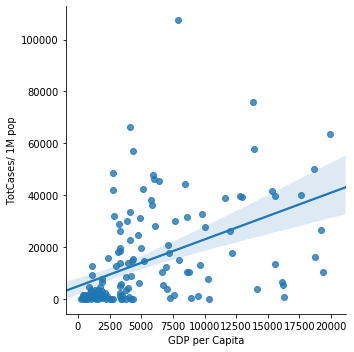

In [33]:
sns.lmplot(x='GDP per Capita', y='TotCases/ 1M pop', data=combine_developing, fit_reg=True);

In [34]:
outcome_6, predictors_6 = patsy.dmatrices('Q("TotCases/ 1M pop") ~ Q("GDP per Capita")', combine_developing)
mod_6 = sm.OLS(outcome_6, predictors_6)
res_6 = mod_6.fit()
print(res_6.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("TotCases/ 1M pop")   R-squared:                       0.228
Model:                               OLS   Adj. R-squared:                  0.223
Method:                    Least Squares   F-statistic:                     42.32
Date:                   Sat, 27 Feb 2021   Prob (F-statistic):           1.22e-09
Time:                           15:23:40   Log-Likelihood:                -1613.6
No. Observations:                    145   AIC:                             3231.
Df Residuals:                        143   BIC:                             3237.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

Now we are focusing on the countries with less than 20,000 GDP Per Capita.We then plotted GDP per capita against total cases/ 1M population and made a linear model using OLS. Since the R^2 is about 0.228, this is no sufficient evidence to support that the correlation between GDP Per Capita and Total Cases Per 1 Million People for developing countries. 

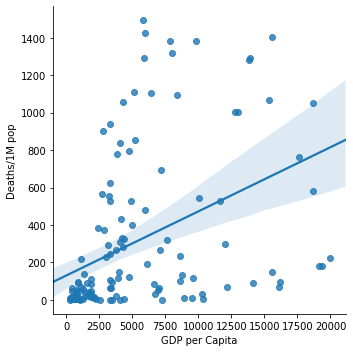

In [35]:
sns.lmplot(x='GDP per Capita', y='Deaths/1M pop', data=combine_developing, fit_reg=True);

In [36]:
outcome, predictors = patsy.dmatrices('Q("Deaths/1M pop") ~ Q("GDP per Capita")', combine_developing)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Deaths/1M pop")   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     27.69
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           5.55e-07
Time:                        15:23:41   Log-Likelihood:                -992.46
No. Observations:                 135   AIC:                             1989.
Df Residuals:                     133   BIC:                             1995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             129.6668    

Now we are focusing on the countries with less than 20,000 GDP Per Capita. We plotted GDP per capita against total cases/ 1M population and made a linear model using OLS. Since the R^2 is about 0.17, there is still no sufficient evidence to support that the correlation between GDP Per Capita and Total Deaths Per 1 Million People for developing countries. 

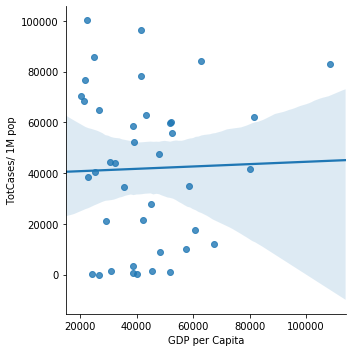

In [37]:
sns.lmplot(x='GDP per Capita', y='TotCases/ 1M pop', data=combine_developed, fit_reg=True);

In [38]:
outcome, predictors = patsy.dmatrices('Q("TotCases/ 1M pop") ~ Q("GDP per Capita")', combine_developed)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("TotCases/ 1M pop")   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.025
Method:                    Least Squares   F-statistic:                   0.03073
Date:                   Sat, 27 Feb 2021   Prob (F-statistic):              0.862
Time:                           15:23:42   Log-Likelihood:                -469.41
No. Observations:                     40   AIC:                             942.8
Df Residuals:                         38   BIC:                             946.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

Now we are focusing on the countries with more than 20,000 GDP Per Capita.We then plotted GDP per capita against total cases/ 1M population and made a linear model using OLS. Since the R^2 is about 0.001, this is no sufficient evidence to support that the correlation between GDP Per Capita and Total Cases Per 1 Million People for developed countries. 

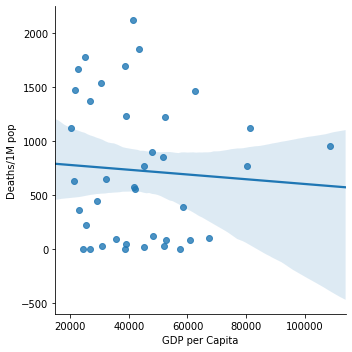

In [39]:
sns.lmplot(x='GDP per Capita', y='Deaths/1M pop', data=combine_developed, fit_reg=True);

In [ ]:
combine_developed_outlier = combine_developed[combine_developed['Deaths/1M pop'] > 2000]
combine_developed_outlier

San Marino had the significant high death rate among other developed countries, and it may cause the correlation and R^2 to be inaccurate between GDP Per Capita and Total Death Rate Per 1 Million People.

In [40]:
outcome, predictors = patsy.dmatrices('Q("Deaths/1M pop") ~ Q("GDP per Capita")', combine_developing)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Deaths/1M pop")   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     27.69
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           5.55e-07
Time:                        15:23:43   Log-Likelihood:                -992.46
No. Observations:                 135   AIC:                             1989.
Df Residuals:                     133   BIC:                             1995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             129.6668    

Now we are focusing on the countries with more than 20,000 GDP Per Capita.We then plotted GDP per capita against total cases/ 1M population and made a linear model using OLS. Since the R^2 is about 0.172, this is no sufficient evidence to support that the correlation between GDP Per Capita and Total Cases Per 1 Million People for developed countries. 